<a href="https://colab.research.google.com/github/sundar-nallalagappan/CatvsDogs/blob/main/CatsVsDogs_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
print("Sairam")

Sairam


https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C2/W3/ungraded_lab/C2_W3_Lab_1_transfer_learning.ipynb

In [12]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-17 04:41:45--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  25.5MB/s    in 3.3s    

2023-06-17 04:41:49 (25.5 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape=(150,150,3),
            include_top = False,
            weights=None)

pre_trained_model.load_weights(local_weights)

for layer in pre_trained_model.layers:
  layer.trainable=False

#All conv layers are instantiated & local weights have been loaded and frozen

In [14]:
pre_trained_model.layers

In [15]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [16]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


Add dense layers for your classifier

In [19]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model

In [20]:
x = layers.Flatten()(last_output)
x = Dense(1024, "relu")(x)
x = layers.Dropout(0.2)(x)
x = Dense(1, "sigmoid")(x)

model = Model(pre_trained_model.input, x)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 74, 74, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                              

In [22]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

Prepare the dataset

In [23]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-06-17 04:45:23--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 74.125.128.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  20.6MB/s    in 3.2s    

2023-06-17 04:45:26 (20.6 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [24]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

In [25]:
# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


In [26]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [27]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 37s - loss: 0.3349 - accuracy: 0.8615 - val_loss: 0.1047 - val_accuracy: 0.9590 - 37s/epoch - 369ms/step
Epoch 2/20
100/100 - 19s - loss: 0.2118 - accuracy: 0.9205 - val_loss: 0.1018 - val_accuracy: 0.9590 - 19s/epoch - 193ms/step
Epoch 3/20
100/100 - 21s - loss: 0.1762 - accuracy: 0.9255 - val_loss: 0.1002 - val_accuracy: 0.9590 - 21s/epoch - 214ms/step
Epoch 4/20
100/100 - 21s - loss: 0.1621 - accuracy: 0.9300 - val_loss: 0.0817 - val_accuracy: 0.9670 - 21s/epoch - 210ms/step
Epoch 5/20
100/100 - 19s - loss: 0.1706 - accuracy: 0.9360 - val_loss: 0.0897 - val_accuracy: 0.9660 - 19s/epoch - 194ms/step
Epoch 6/20
100/100 - 20s - loss: 0.1842 - accuracy: 0.9330 - val_loss: 0.1054 - val_accuracy: 0.9640 - 20s/epoch - 205ms/step
Epoch 7/20
100/100 - 20s - loss: 0.1591 - accuracy: 0.9420 - val_loss: 0.0871 - val_accuracy: 0.9700 - 20s/epoch - 196ms/step
Epoch 8/20
100/100 - 20s - loss: 0.1459 - accuracy: 0.9460 - val_loss: 0.0888 - val_accuracy: 0.9660 - 20s/epoch - 203

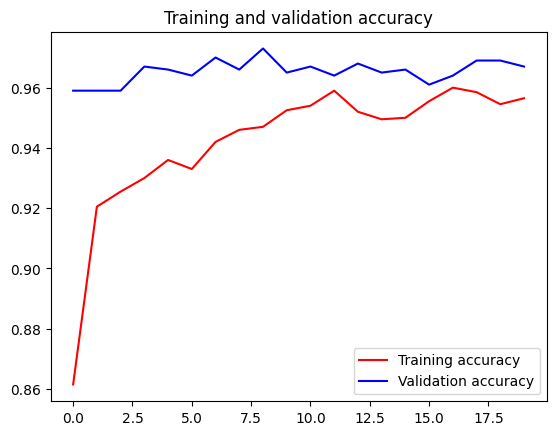

<Figure size 640x480 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()